We begin by loading the raw dataset ('train.csv') in and importing core packages for dataframe manipulation, data visualization and model creation.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train (1).csv


In [ ]:
#Importing packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import seaborn as sns
import collections
from scipy.stats import loguniform

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

from sklearn import linear_model, metrics, svm
from sklearn.linear_model import Ridge, LinearRegression, Lasso, RidgeCV, LassoCV, LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, learning_curve, train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, f1_score,recall_score, precision_score
from sklearn.svm import SVC,LinearSVC
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import VotingClassifier


#Setting up matplotlib for plots
%matplotlib inline

The dataset is processed into a dataframe and refactored in numerous ways: upwards of 300 duplicates are dropped, the 'Name' feature is converted from String to boolean by assigning 1 to named animals and 0 otherwise, age is refactored into a double and missing entries in sex and outcome subtype are filled in appropriately.

In [ ]:
# creating the main dataframe, to be later split in a training set and test set 
trainData = pd.read_csv("train.csv")

# dropping duplicates
trainData.drop_duplicates(subset=['Name','DateTime','OutcomeType','OutcomeSubtype','AnimalType','SexuponOutcome','AgeuponOutcome','Breed','Color'],keep='first',inplace=True)

# refactoring name into boolean =1 if a name exists, 0 otherwise
trainData.loc[:, 'Name'] = trainData.loc[:,'Name'].fillna(0)
trainData.loc[trainData['Name'] != 0, 'Name'] = 1
trainData.loc[:, 'Name'] = pd.to_numeric(trainData.loc[:,'Name'])

# refactoring age into double and dropping NaN rows
trainData.loc[:, 'AgeuponOutcome'] = trainData.loc[:, 'AgeuponOutcome'].str.split()
trainData.loc[trainData['AgeuponOutcome'].str[1] == "year", 'Age'] = pd.to_numeric(trainData.loc[:, 'AgeuponOutcome'].str[0])*365.25
trainData.loc[trainData['AgeuponOutcome'].str[1] == "years", 'Age'] = pd.to_numeric(trainData.loc[:,'AgeuponOutcome'].str[0])*365.25
trainData.loc[trainData['AgeuponOutcome'].str[1] == "month", 'Age'] = pd.to_numeric(trainData.loc[:,'AgeuponOutcome'].str[0])*30.4375
trainData.loc[trainData['AgeuponOutcome'].str[1] == "months", 'Age'] = pd.to_numeric(trainData.loc[:,'AgeuponOutcome'].str[0])*30.4375
trainData.loc[trainData['AgeuponOutcome'].str[1] == "week", 'Age'] = pd.to_numeric(trainData.loc[:,'AgeuponOutcome'].str[0])*7
trainData.loc[trainData['AgeuponOutcome'].str[1] == "weeks", 'Age'] = pd.to_numeric(trainData.loc[:,'AgeuponOutcome'].str[0])*7
trainData.loc[trainData['AgeuponOutcome'].str[1] == "day", 'Age'] = pd.to_numeric(trainData.loc[:,'AgeuponOutcome'].str[0])
trainData.loc[trainData['AgeuponOutcome'].str[1] == "days", 'Age'] = pd.to_numeric(trainData.loc[:,'AgeuponOutcome'].str[0])

# refactoring date of outcome to be a datetime object
trainData.loc[:, 'DateTime'] = pd.to_datetime(trainData.loc[:,'DateTime'])

# filling in missing outcome subtypes
trainData.loc[trainData['OutcomeType']=='Adoption','OutcomeSubtype'] = trainData.loc[trainData['OutcomeType']=='Adoption','OutcomeSubtype'].fillna('Standard Adoption')
trainData.loc[trainData['OutcomeType']=='Died','OutcomeSubtype'] = trainData.loc[trainData['OutcomeType']=='Died','OutcomeSubtype'].fillna('Other Death')
trainData.loc[trainData['OutcomeType']=='Euthanasia','OutcomeSubtype'] = trainData.loc[trainData['OutcomeType']=='Euthanasia','OutcomeSubtype'].fillna('Other Euthanasia')
trainData.loc[trainData['OutcomeType']=='Return_to_owner','OutcomeSubtype']=trainData.loc[trainData['OutcomeType']=='Return_to_owner','OutcomeSubtype'].fillna('Standard RTO')
trainData.loc[trainData['OutcomeType']=='Transfer','OutcomeSubtype'] = trainData.loc[trainData['OutcomeType']=='Transfer','OutcomeSubtype'].fillna('Other Transfer')


# filling in missing ages, sex
trainData.loc[:,'SexuponOutcome'] = trainData.loc[:,'SexuponOutcome'].fillna('Unknown')

# Dropping rows with non-defined ages (only feature not filled in)
trainData = trainData.dropna()
trainData = trainData.reset_index(drop=True)

# sneak peek
print(trainData.shape)
print (trainData.head(10))


(26375, 11)
  AnimalID  Name            DateTime      OutcomeType     OutcomeSubtype  \
0  A671945     1 2014-02-12 18:22:00  Return_to_owner       Standard RTO   
1  A656520     1 2013-10-13 12:44:00       Euthanasia          Suffering   
2  A686464     1 2015-01-31 12:28:00         Adoption             Foster   
3  A683430     0 2014-07-11 19:09:00         Transfer            Partner   
4  A667013     0 2013-11-15 12:52:00         Transfer            Partner   
5  A677334     1 2014-04-25 13:04:00         Transfer            Partner   
6  A699218     1 2015-03-28 13:11:00         Transfer            Partner   
7  A701489     0 2015-04-30 17:02:00         Transfer            Partner   
8  A671784     1 2014-02-04 17:17:00         Adoption  Standard Adoption   
9  A677747     0 2014-05-03 07:48:00         Adoption            Offsite   

  AnimalType SexuponOutcome AgeuponOutcome                              Breed  \
0        Dog  Neutered Male      [1, year]              Shetland Sheep

We look at both a count chart and a pie chart of the outcomes. An imbalance is immediately apparent in the occurrence of outcomes, with adoptions and transfers jointly taking up 75% of the individuals while a little less than 1% of the dataset is registered as deceased. As previously stated, this makes it very likely that predictions of death and euthanasia will be sparse (they jointly cover about 7% of entries) and correlations between these outcomes and the features of animals befallen by them will not be very strong; the opposite is intuitively expected for adoptions and transfers, with returns to owner falling somewhere between the two extremes.

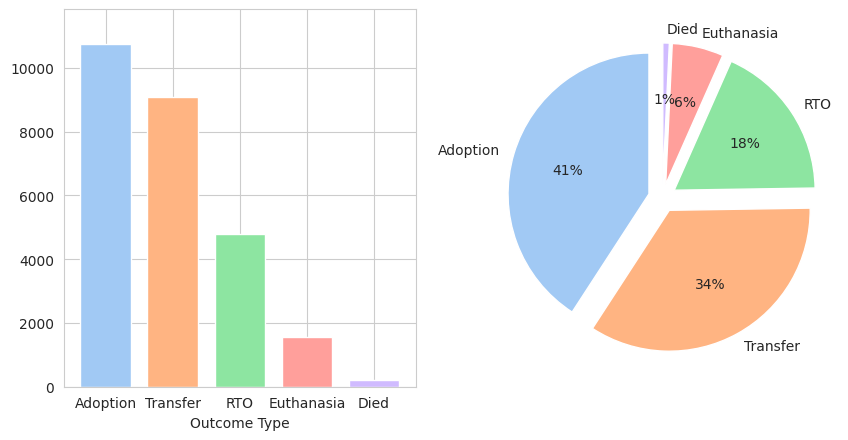

In [ ]:
# data visualizaiton: outcome type pie chart + count plot
trainData.loc[trainData['OutcomeType']=='Return_to_owner', 'OutcomeType'] = 'RTO'
colors = sns.color_palette('pastel')
sns.set_style('whitegrid')
vc = trainData.OutcomeType.value_counts()
labels = vc.index
fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=100)
p1 = vc.plot(kind='bar', ax=axes[0], color=colors, rot=0, xlabel='Outcome Type', width=.75)
blabels = [f'{(v / vc.sum())*100:0.0f}%' for v in vc]
axes[0].margins(y=0.1)
axes[1].pie(vc, labels=labels, autopct="%1.0f%%", startangle=90, explode=tuple([0.1] * len(labels)), colors=colors)
plt.show()

Each outcome is studied through 3 visual aids, which overall encompass 6 of the 8 relevant features in the dataset. The two that are left out – breed and colour – are too diverse to be visualised meaningfully, since lots of breeds are mixes between other breeds (or even other mixes) and there are anywhere between 2 and 8 terms describing certain colour nuances. 

In [ ]:
# adding 'years' column as 'Age' transformation for exploratory analysis
trainData.loc[:,'Years'] = pd.to_numeric(trainData['Age'])/365.25

Adopted animals immediately show a positive correlation between age and being named, unsurprisingly suggesting that fostered or adopted animals are less likely to have been named when they are extremely young. The confidence intervals for age are relatively tight in most features, except for intact male and female dogs. Together with the notably higher average, this suggests a comparatively smaller population of this specific type-sex combination. Also noteworthy is the drastically lower average age of adopted cats, as well as the fact that most cats appear to be neutered or spayed at very young ages. Lastly, Christmas and summer seem to be peak adoption season, contrasting with the noticeable dip of early spring. While the reason for the latter is more obscure, the former is likely justified by the higher salience of pets and wider range of activities pets can be included in during summer, as well as children commonly receiving substantial gifts (such as a cute adopted pet) for the seasons’ holidays. Moving forward, our expectation is thus that older – especially intact – cats, unnamed pets and spring adoptions will be comparatively harder to predict or strongly correlate to specific features.

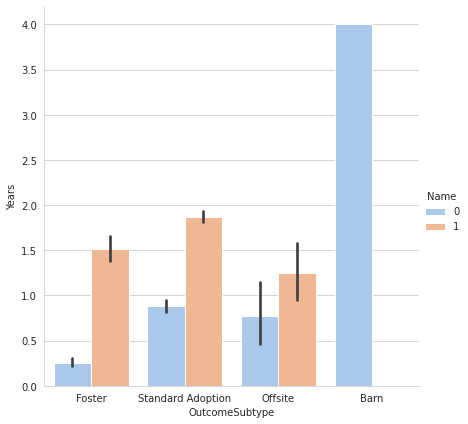

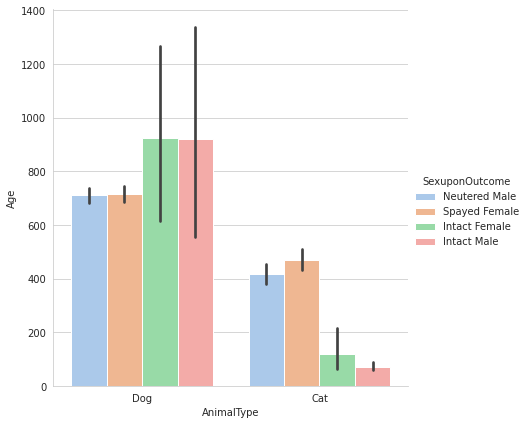

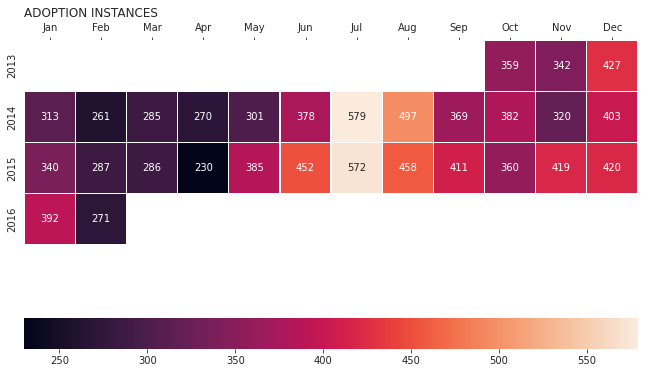

In [ ]:
# data visualization: Adoption outcome
# Name, Age and Outcome Subtype
sns.set_style('whitegrid')
xSeries = trainData.loc[trainData['OutcomeType']=='Adoption','OutcomeSubtype']
sns.catplot(x='OutcomeSubtype', y = 'Years', hue = 'Name', data =  trainData.loc[trainData['OutcomeType']=='Adoption'], palette = 'pastel',  kind='bar' ,  height=6, aspect=1)
# Animal Type, Sex and Age
sns.catplot(x='AnimalType', y='Age',
                hue='SexuponOutcome',
                data=trainData.loc[trainData['OutcomeType']=='Adoption'], kind="bar",
                height=6, aspect=1,palette = 'pastel');
# Date-Time Occurences
# read smaller frame
plotFrame = pd.read_csv("/content/drive/MyDrive/Data/Shelter Animal Outcomes/train.csv", 
                 usecols=[2,3], names=['DateTime', 'OutcomeType'], 
                 skiprows=1, index_col=0, parse_dates=[0])
# reshape data
plotFrame.loc[plotFrame['OutcomeType']!='Adoption', 'OutcomeType'] = 0;
plotFrame.loc[plotFrame['OutcomeType']=='Adoption', 'OutcomeType'] = 1;
plotFrame['OutcomeType'] = pd.to_numeric(plotFrame['OutcomeType'])
plotFrame['month'] = [i.month for i in plotFrame.index]
plotFrame['year'] = [i.year for i in plotFrame.index]
plotFrame = plotFrame.groupby(['month', 'year']).sum()
plotFrame = plotFrame.unstack(level=0)
#plot
fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(plotFrame, square = True, linewidth=0.3, annot=True, fmt=".0f", cbar_kws={"orientation": "horizontal"})
ax.xaxis.tick_top()
xticks_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(np.arange(12) + .5, labels=xticks_labels)
plt.xlabel('')
plt.ylabel('')
title = 'Adoption Instances'.upper()
plt.title(title, loc='left')
plt.show()


Returns to owner stand out as having a single subtype, with the same clear average age surplus for named animals. Compared to adoptions, we clearly see more uniform distributions when it comes to both the occurrence count over time and the average age between cats and dogs. An exception to the latter is given by animals of unknown sex and intact male cats; this exception, as well as the wide confidence intervals of the exceptional features, stems from low individual counts, which may become a concern for model accuracy later. While it is unclear whether the dramatically large confidence interval for the age of intact female cats stems from a fat-tailed distribution or sparse data, this specific type-sex combination should also be watched closely. While lost baby animals may be difficult to predict because of the overall high average age, the return-to-owner outcome seems better distributed over time, sex, and age than adoptions, hopefully leading to more accurate predictions.

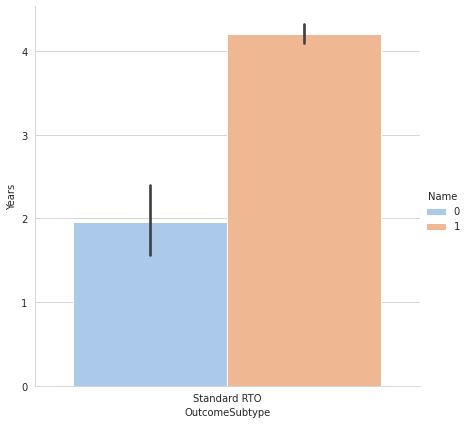

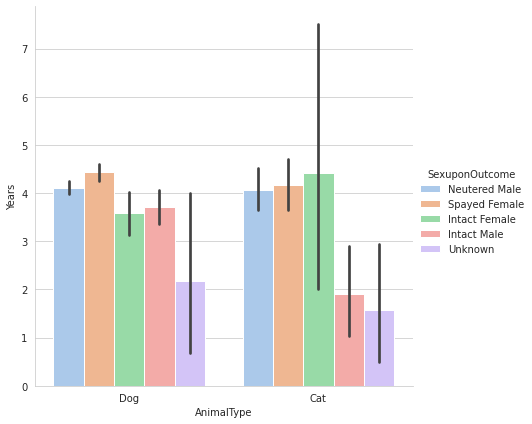

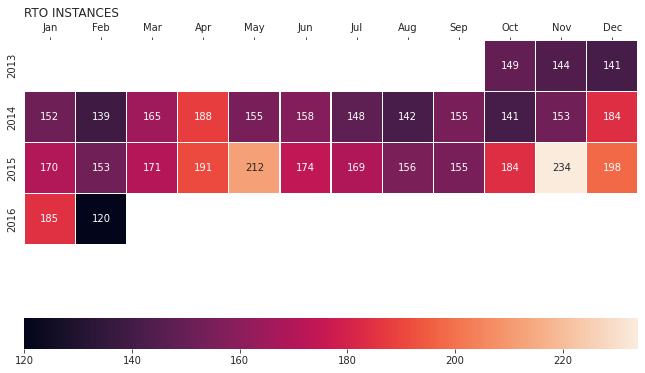

In [ ]:
# data visualization: RTO outcome
# Name, Age and Outcome Subtype
sns.set_style('whitegrid')
xSeries = trainData.loc[trainData['OutcomeType']=='RTO','OutcomeSubtype']
sns.catplot(x='OutcomeSubtype', y = 'Years', hue = 'Name', data =  trainData.loc[trainData['OutcomeType']=='RTO'], palette = 'pastel',  kind='bar' ,  height=6, aspect=1)
# Animal Type, Sex and Age
sns.catplot(x='AnimalType', y='Years',
                hue='SexuponOutcome',
                data=trainData.loc[trainData['OutcomeType']=='RTO'], kind="bar",
                height=6, aspect=1,palette = 'pastel');
# Date-Time Occurences
# read smaller frame
plotFrame = pd.read_csv("/content/drive/MyDrive/Data/Shelter Animal Outcomes/train.csv", 
                 usecols=[2,3], names=['DateTime', 'OutcomeType'], 
                 skiprows=1, index_col=0, parse_dates=[0])
# reshape data
plotFrame.loc[plotFrame['OutcomeType']!='Return_to_owner', 'OutcomeType'] = 0;
plotFrame.loc[plotFrame['OutcomeType']=='Return_to_owner', 'OutcomeType'] = 1;
plotFrame['OutcomeType'] = pd.to_numeric(plotFrame['OutcomeType'])
plotFrame['month'] = [i.month for i in plotFrame.index]
plotFrame['year'] = [i.year for i in plotFrame.index]
plotFrame = plotFrame.groupby(['month', 'year']).sum()
plotFrame = plotFrame.unstack(level=0)
#plot
fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(plotFrame, square = True, linewidth=0.3, annot=True, fmt=".0f", cbar_kws={"orientation": "horizontal"})
ax.xaxis.tick_top()
xticks_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(np.arange(12) + .5, labels=xticks_labels)
plt.xlabel('')
plt.ylabel('')
title = 'RTO Instances'.upper()
plt.title(title, loc='left')
plt.show()


In the interest of the report’s space economy, we only discuss the most important observations over the transfer, euthanasia, and death outcomes. This is further justified by the previously discussed low preponderance of these outcomes, totalling just about 25% of the dataset, which constitutes a reason for concern over prediction accuracy by default. Large confidence intervals are comparatively more prevalent than in the earlier outcomes; this can indeed just be a consequence of data sparsity, but it will likely serve to fit the rare occurrences more easily through these high-variance features and thus somewhat compensate the inherently lower prediction accuracy. Much like adoption, transfers occur at disproportionately young ages compared to returns, deaths, and euthanasia administrations, which is likely to skew age-based prediction. We make a final note about specific feature combinations that are simply not present, such as adopted, named barn animals or euthanised, unnamed animals involved in a court investigation. While these may be problematic if a different test set was used, splitting the only dataset in 80-20 training/test data makes so that neither subset can contain individuals with the exact missing feature combinations, so these missing entries will not affect accuracy. 

In [ ]:
# data visualization: Transfer outcome
# Name, Age and Outcome Subtype
sns.set_style('whitegrid')
xSeries = trainData.loc[trainData['OutcomeType']=='Transfer','OutcomeSubtype']

sns.catplot(x='OutcomeSubtype', y = 'Years', hue = 'Name', data =  trainData.loc[trainData['OutcomeType']=='Transfer'], palette = 'pastel',  kind='bar' ,  height=6, aspect=1)
# Animal Type, Sex and Age
sns.catplot(x='AnimalType', y='Years',
                hue='SexuponOutcome',
                data=trainData.loc[trainData['OutcomeType']=='Transfer'], kind="bar",
                height=6, aspect=1,palette = 'pastel');
# Date-Time Occurences
# read smaller frame
plotFrame = pd.read_csv("/content/drive/MyDrive/Data/Shelter Animal Outcomes/train.csv", 
                 usecols=[2,3], names=['DateTime', 'OutcomeType'], 
                 skiprows=1, index_col=0, parse_dates=[0])
# reshape data
plotFrame.loc[plotFrame['OutcomeType']!='Transfer', 'OutcomeType'] = 0;
plotFrame.loc[plotFrame['OutcomeType']=='Transfer', 'OutcomeType'] = 1;
plotFrame['OutcomeType'] = pd.to_numeric(plotFrame['OutcomeType'])
plotFrame['month'] = [i.month for i in plotFrame.index]
plotFrame['year'] = [i.year for i in plotFrame.index]
plotFrame = plotFrame.groupby(['month', 'year']).sum()
plotFrame = plotFrame.unstack(level=0)
#plot
fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(plotFrame, square = True, linewidth=0.3, annot=True, fmt=".0f", cbar_kws={"orientation": "horizontal"})
ax.xaxis.tick_top()
xticks_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(np.arange(12) + .5, labels=xticks_labels)
plt.xlabel('')
plt.ylabel('')
title = 'Transfer Instances'.upper()
plt.title(title, loc='left')
plt.show()


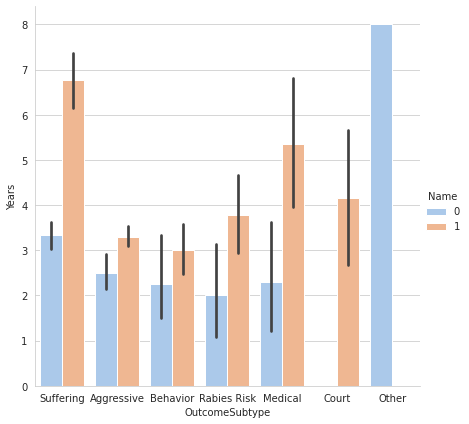

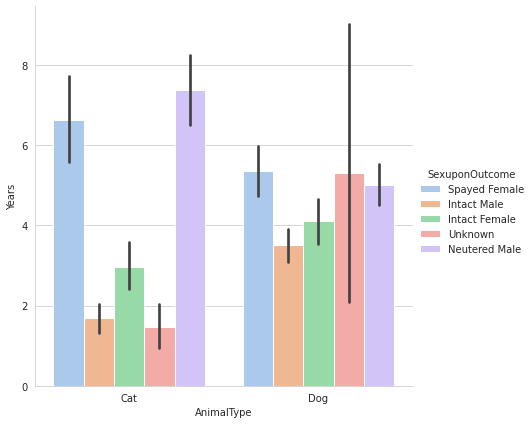

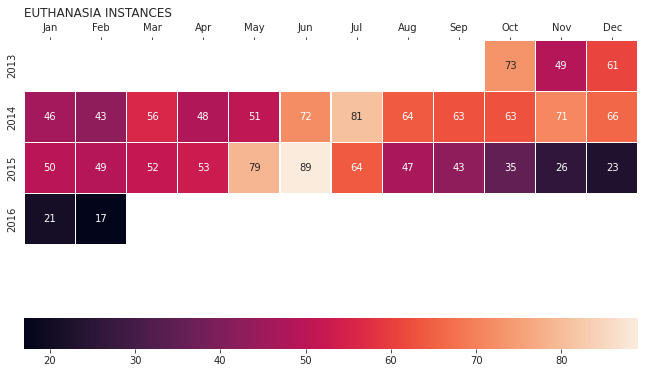

In [ ]:
# data visualization: Euthanasia outcome
# Name, Age and Outcome Subtype
sns.set_style('whitegrid')
trainData.loc[trainData['OutcomeSubtype']=='Court/Investigation', 'OutcomeSubtype'] = 'Court'
trainData.loc[trainData['OutcomeSubtype']=='Other Euthanasia', 'OutcomeSubtype'] = 'Other'
xSeries = trainData.loc[trainData['OutcomeType']=='Euthanasia','OutcomeSubtype']
sns.catplot(x='OutcomeSubtype', y = 'Years', hue = 'Name', data =  trainData.loc[trainData['OutcomeType']=='Euthanasia'], palette = 'pastel',  kind='bar' ,  height=6, aspect=1)
# Animal Type, Sex and Age
sns.catplot(x='AnimalType', y='Years',
                hue='SexuponOutcome',
                data=trainData.loc[trainData['OutcomeType']=='Euthanasia'], kind="bar",
                height=6, aspect=1,palette = 'pastel');
# Date-Time Occurences
# read smaller frame
plotFrame = pd.read_csv("/content/drive/MyDrive/Data/Shelter Animal Outcomes/train.csv", 
                 usecols=[2,3], names=['DateTime', 'OutcomeType'], 
                 skiprows=1, index_col=0, parse_dates=[0])
# reshape data
plotFrame.loc[plotFrame['OutcomeType']!='Euthanasia', 'OutcomeType'] = 0;
plotFrame.loc[plotFrame['OutcomeType']=='Euthanasia', 'OutcomeType'] = 1;
plotFrame['OutcomeType'] = pd.to_numeric(plotFrame['OutcomeType'])
plotFrame['month'] = [i.month for i in plotFrame.index]
plotFrame['year'] = [i.year for i in plotFrame.index]
plotFrame = plotFrame.groupby(['month', 'year']).sum()
plotFrame = plotFrame.unstack(level=0)
#plot
fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(plotFrame, square = True, linewidth=0.3, annot=True, fmt=".0f", cbar_kws={"orientation": "horizontal"})
ax.xaxis.tick_top()
xticks_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(np.arange(12) + .5, labels=xticks_labels)
plt.xlabel('')
plt.ylabel('')
title = 'Euthanasia Instances'.upper()
plt.title(title, loc='left')
plt.show()


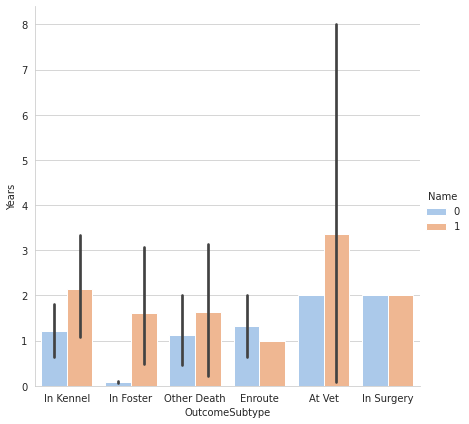

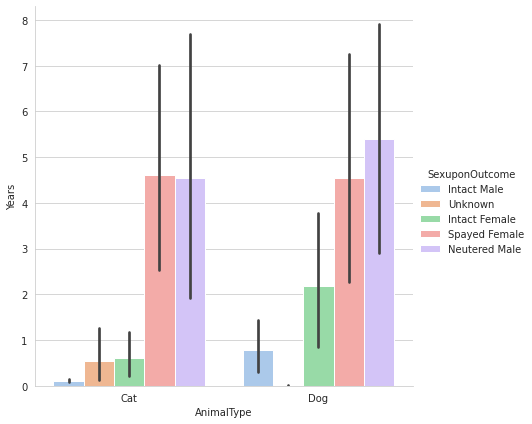

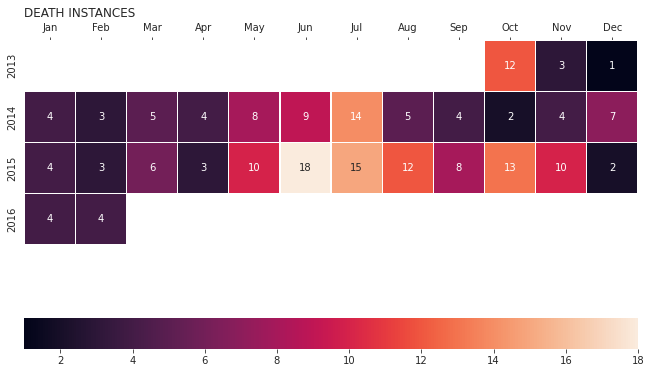

In [ ]:
# data visualization: Death outcome
# Name, Age and Outcome Subtype
sns.set_style('whitegrid')
xSeries = trainData.loc[trainData['OutcomeType']=='Died','OutcomeSubtype']
sns.catplot(x='OutcomeSubtype', y = 'Years', hue = 'Name', data =  trainData.loc[trainData['OutcomeType']=='Died'], palette = 'pastel',  kind='bar' ,  height=6, aspect=1)
# Animal Type, Sex and Age
sns.catplot(x='AnimalType', y='Years',
                hue='SexuponOutcome',
                data=trainData.loc[trainData['OutcomeType']=='Died'], kind="bar",
                height=6, aspect=1,palette = 'pastel');
# Date-Time Occurences
# read smaller frame
plotFrame = pd.read_csv("/content/drive/MyDrive/Data/Shelter Animal Outcomes/train.csv", 
                 usecols=[2,3], names=['DateTime', 'OutcomeType'], 
                 skiprows=1, index_col=0, parse_dates=[0])
# reshape data
plotFrame.loc[plotFrame['OutcomeType']!='Died', 'OutcomeType'] = 0;
plotFrame.loc[plotFrame['OutcomeType']=='Died', 'OutcomeType'] = 1;
plotFrame['OutcomeType'] = pd.to_numeric(plotFrame['OutcomeType'])
plotFrame['month'] = [i.month for i in plotFrame.index]
plotFrame['year'] = [i.year for i in plotFrame.index]
plotFrame = plotFrame.groupby(['month', 'year']).sum()
plotFrame = plotFrame.unstack(level=0)
#plot
fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(plotFrame, square = True, linewidth=0.3, annot=True, fmt=".0f", cbar_kws={"orientation": "horizontal"})
ax.xaxis.tick_top()
xticks_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(np.arange(12) + .5, labels=xticks_labels)
plt.xlabel('')
plt.ylabel('')
title = 'Death Instances'.upper()
plt.title(title, loc='left')
plt.show()


Additional re-formating of String data to categorical, numerically-encoded variables:

*   Dogs are assigned value 0 while cats are assigned 1.
*   Males - both intact and neutered - are assigned value -1, females are assigned 1, and unknown sex is assigned 0. This separates sex from sterilisation status.
*   'Sterilisation' column added, with value -1 for intact animals, 1 for sterilised ones, and 0 for unknown status.
*   Outcomes re-grouped in 3 categories: adoptions are returns to owner are assigned value 0 (considered 'with family'), transfers are assigned value 1 (considered 'in the system'), while euthanasias and death are assigned value 2 (considered 'dead').
*   'Mix' feature of breed is manually hot-encoded
*   The pigmentation features of 'Colour' are manually hot-encoded to values roughly corresponding to eumelanin and pheomelanin production. This is based on a personal hunch.

In [ ]:
# Reverting RTO to Return_to_owner
trainData.loc[trainData['OutcomeType']=='RTO', 'OutcomeType'] = 'Return_to_owner'

# Animal: Dog (0) vs Cat (1)
trainData.loc[trainData['AnimalType'] == 'Dog', 'Animal'] = 0
trainData.loc[trainData['AnimalType'] == 'Cat', 'Animal'] = 1

# Sex: Male (-1) vs Unknown (0) vs Female (1)
trainData.loc[trainData['SexuponOutcome'] == 'Intact Male', 'Sex'] = -1
trainData.loc[trainData['SexuponOutcome'] == 'Intact Female', 'Sex'] = 1
trainData.loc[trainData['SexuponOutcome'] == 'Unknown', 'Sex'] = 0
trainData.loc[trainData['SexuponOutcome'] == 'Neutered Male', 'Sex'] = -1
trainData.loc[trainData['SexuponOutcome'] == 'Spayed Female', 'Sex'] = 1

# Sterilisation status: Sterilised (-1) vs Unknown (0) vs Unsterilised (1)
trainData.loc[trainData['SexuponOutcome'] == 'Intact Male', 'Sterilised'] = -1
trainData.loc[trainData['SexuponOutcome'] == 'Intact Female', 'Sterilised'] = -1
trainData.loc[trainData['SexuponOutcome'] == 'Unknown', 'Sterilised'] = 0
trainData.loc[trainData['SexuponOutcome'] == 'Neutered Male', 'Sterilised'] = 1
trainData.loc[trainData['SexuponOutcome'] == 'Spayed Female', 'Sterilised'] = 1

# Outcome: With Family (-1) vs In The System (0) vs Dead (1)
trainData.loc[trainData['OutcomeType'] == 'Return_to_owner','Outcome'] = 0
trainData.loc[trainData['OutcomeType'] == 'Adoption', 'Outcome'] = 0
trainData.loc[trainData['OutcomeType'] == 'Transfer', 'Outcome'] = 1
trainData.loc[trainData['OutcomeType'] == 'Euthanasia', 'Outcome'] = 2
trainData.loc[trainData['OutcomeType'] == 'Died', 'Outcome'] = 2

# Breed (pure vs mix)
def get_mix(x):
  x = str(x)
  if x.find('Mix')>=0:return 1
  return 0
trainData['Mix'] = trainData.Breed.apply(get_mix)

# Coat colour: whether eumelanin and pheomelanin are present, and in what amount

# Cool hues (eumelanin)
def get_cool(x):
  x = str(x)
  if x.find('Black')>=0:return 1
  if x.find('White')>=0:return 1
  if x.find('Silver')>=0:return 1
  if x.find('Smoke')>=0:return 1
  if x.find('Gray')>=0:return 1
  if x.find('Blue')>=0:return 1
  return 0
trainData['Cool'] = trainData.Color.apply(get_cool)

# Warm hues (pheomelanin)
def get_warm(x):
  x = str(x)
  if x.find('Brown')>=0:return 1
  if x.find('Cream')>=0:return 1
  if x.find('Tan')>=0:return 1
  if x.find('Red')>=0:return 1
  if x.find('Orange')>=0:return 1
  if x.find('Chocolate')>=0:return 1
  if x.find('Yellow')>=0:return 1
  if x.find('Gold')>=0:return 1
  if x.find('Buff')>=0:return 1
  if x.find('Fawn')>=0:return 1
  if x.find('Apricot')>=0:return 1
  return 0
trainData['Warm'] = trainData.Color.apply(get_warm)

# Dark shades
def get_dark(x):
  x = str(x)
  if x.find('Black')>=0:return 1
  if x.find('Brown')>=0:return 1
  if x.find('Liver')>=0:return 1
  if x.find('Chocolate')>=0:return 1
  return 0
trainData['Dark'] = trainData.Color.apply(get_dark)

# Light shades
def get_light(x):
  x = str(x)
  if x.find('White')>=0:return 1
  if x.find('Pink')>=0:return 1
  return 0
trainData['Light'] = trainData.Color.apply(get_light)

# Medium shades
def get_medium(x):
  x = str(x)
  if x.find('Silver')>=0:return 1
  if x.find('Smoke')>=0:return 1
  if x.find('Gray')>=0:return 1
  if x.find('Blue')>=0:return 1
  if x.find('Cream')>=0:return 1
  if x.find('Tan')>=0:return 1
  if x.find('Red')>=0:return 1
  if x.find('Orange')>=0:return 1
  if x.find('Yellow')>=0:return 1
  if x.find('Gold')>=0:return 1
  if x.find('Buff')>=0:return 1
  if x.find('Fawn')>=0:return 1
  if x.find('Apricot')>=0:return 1
  return 0
trainData['Medium'] = trainData.Color.apply(get_medium)

In [ ]:
# printing final feature list to be used in models
print(trainData.loc[:,['Animal','Age','Name','Sex','Sterilised','Mix','Warm','Cool','Dark','Medium','Light']])

       Animal        Age  Name  Sex  Sterilised  Mix  Warm  Cool  Dark  \
0         0.0   365.2500     1 -1.0         1.0    1     1     1     1   
1         1.0   365.2500     1  1.0         1.0    1     1     0     0   
2         0.0   730.5000     1 -1.0         1.0    1     0     1     0   
3         1.0    21.0000     0 -1.0        -1.0    1     1     1     0   
4         0.0   730.5000     0 -1.0         1.0    0     1     0     0   
...       ...        ...   ...  ...         ...  ...   ...   ...   ...   
26724     1.0    30.4375     0 -1.0        -1.0    1     1     1     1   
26725     1.0    91.3125     0  1.0         1.0    1     1     0     1   
26726     0.0  1461.0000     1 -1.0         1.0    1     1     1     0   
26727     1.0    28.0000     0 -1.0        -1.0    1     0     1     1   
26728     1.0   365.2500     0 -1.0        -1.0    1     1     1     1   

       Medium  Light  
0           0      1  
1           1      0  
2           1      1  
3           1      

The features are separated from the label, and the dataset is partitioned into the 80% training 20% test combination discussed earlier.

In [ ]:
X = trainData.loc[:,['Name','Sex','Sterilised','Age','Animal','Mix','Warm','Cool','Dark','Medium','Light']]
y = trainData.loc[:,'Outcome']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, stratify=y,random_state=42)

Using a randomised search to explore and decide logistic regression hyperparameters. Testing some solvers that work with multiclass data, and some penalties that work with (some) of the solvers. Using F-measure to score, as we expect this will be less likely to underfit the minority class.
Outcome: Best parameters: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 0.01}

In [ ]:
model = LogisticRegression(multi_class='multinomial', max_iter=2000)

space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'saga']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = [100, 10, 1.0, 0.1, 0.01]

random_search = RandomizedSearchCV(model, space, scoring='f1_weighted',random_state = 42)
random_search.fit(X_train,y_train)

print("Best parameters: {}".format(random_search.best_params_))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Sett

Best parameters: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 0.01}
Score=0.728


Using a randomised search to explore and decide KNN hyperparameters.Using F-measure to score, as we expect this will be less likely to underfit the minority class.
Outcome: Best parameters: {'weights': 'uniform', 'n_neighbors': 11, 'metric': 'euclidean'}

In [ ]:
random_search = RandomizedSearchCV(KNN(),
                           {
                              'weights': ['uniform', 'distance'],
                              'metric':['euclidean', 'manhattan', 'minkowski'],
                              'n_neighbors':np.arange(1, 40, 2),
                            },scoring='f1_weighted' ,
                             n_iter=120, random_state = 42
                           )
random_search.fit(X_train,y_train)
print("Best parameters: {}".format(random_search.best_params_))

Best parameters: {'weights': 'uniform', 'n_neighbors': 11, 'metric': 'euclidean'}


Using a randomised search to explore and decide decision tree hyperparameters.Using F-measure to score, as we expect this will be less likely to underfit the minority class. Mainly looking at min_samples_leaf and min_samples_split as well as depth, criterion, and splitter as some of the documented empirical analysis we consulted suggested these are among the most influential features to tweak.
Outcome: Best parameters: {'splitter': 'best', 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 6, 'criterion': 'gini'}

In [ ]:
random_search = RandomizedSearchCV(DecisionTreeClassifier(random_state=42),
                           {
                              'max_depth':np.arange(6, 10, 2),
                              'min_samples_split':np.arange(2, 25, 1),
                            'min_samples_leaf':np.arange(1, 15, 1),
                            'criterion' : ['entropy','gini'],
                            'splitter' : ['best','random'],
                            },scoring="f1_micro", random_state=42,n_iter=4000
                           )
random_search.fit(X_train,y_train)
print("Best parameters: {}".format(random_search.best_params_))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 2576 is smaller than n_iter=4000. Running 2576 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Best parameters: {'splitter': 'best', 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 6, 'criterion': 'gini'}


Fitting a decision tree and reporting performance measures. Plotting the first layers of the tree. The plot can show more layers by tweaking the plot_tree(max_depth).

F:  0.741736872157331
Accuracy:  0.7679620853080569
Recall:  0.7679620853080569
Precision:  0.753255009646511
Predicted values:  Counter({0.0: 3876, 1.0: 1309, 2.0: 90})
Test values:  Counter({0.0: 3109, 1.0: 1816, 2.0: 350})


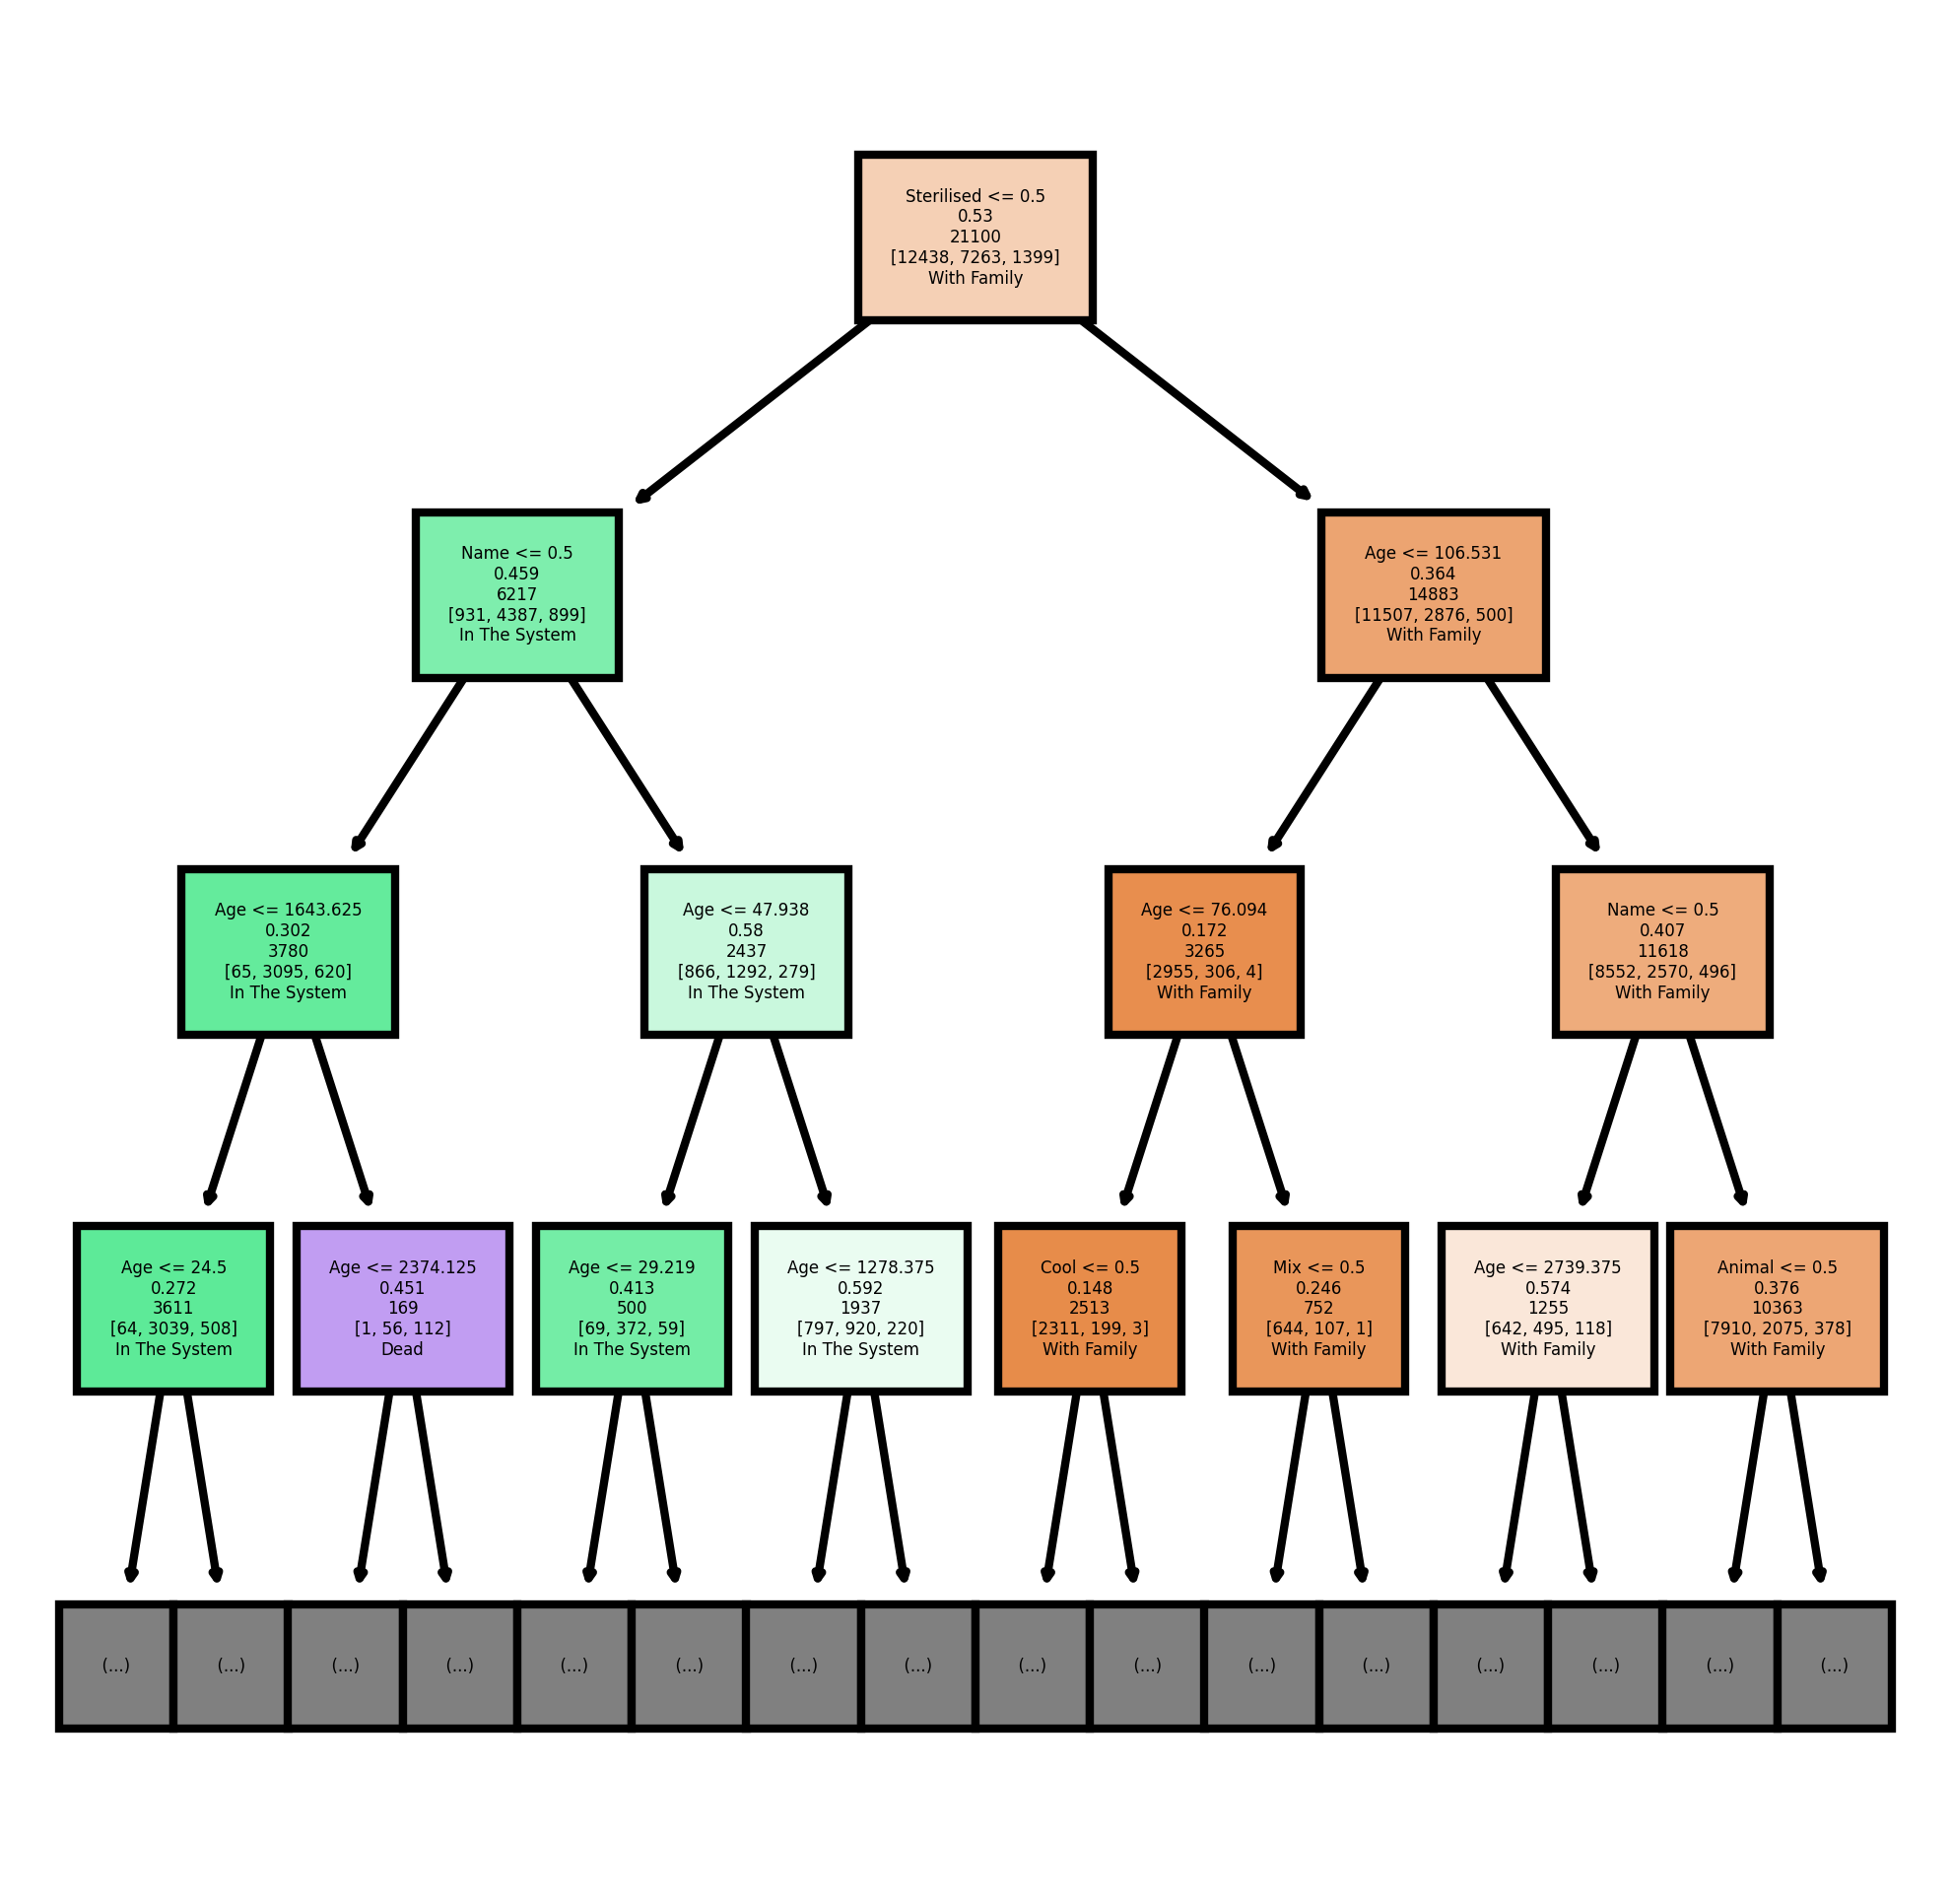

In [ ]:
dt = DecisionTreeClassifier( min_samples_split=2, min_samples_leaf= 3, max_depth= 6, random_state = 42)
dt.fit(X_train,y_train)
from sklearn import tree
fn=['Name','Sex','Sterilised','Age','Animal','Mix','Warm','Cool','Dark','Medium','Light']
cn=['With Family', 'In The System', 'Dead']
fig, axes = plt.subplots(nrows =1,ncols = 1,figsize = (4,4), dpi=600)
tree.plot_tree(dt,
               feature_names = fn, 
               class_names=cn, fontsize=2,max_depth= 3,label='none',filled=True)
y_pred = dt.predict(X_test)
print('F-measure: ', f1_score(y_test, y_pred, average='weighted'))
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred, average='weighted'))
print('Precision: ', precision_score(y_test, y_pred, average='weighted'))
print('Predicted values: ', collections.Counter(y_pred))
print('Test values: ', collections.Counter(y_test))

Fitting all three classifiers that will be used for the voting classifier and printing some performance measures.

In [ ]:
dt = DecisionTreeClassifier( min_samples_split=2, 
                            min_samples_leaf= 3, 
                            max_depth= 6, 
                            random_state = 42)
lr = LogisticRegression(multi_class='multinomial',
                        solver= 'newton-cg', 
                        penalty= 'l2', 
                        C = 0.01,
                        random_state=42, 
                        max_iter=2000)
knn = KNN(metric='euclidean', 
          n_neighbors= 37, 
          weights= 'uniform')

classifiers = [('Logistic Regression', lr), ('K Nearest Neighbours', knn),('Classification Tree', dt)]

for clf_name, clf in classifiers:
  clf.fit(X_train,y_train)
  y_pred = clf.predict(X_test)
  print(clf_name)
  print('F-measure', f1_score(y_test, y_pred, average='weighted'))
  print('Accuracy', accuracy_score(y_test, y_pred))
  print('Predicted Values',collections.Counter(y_pred))
  print('Test Values',collections.Counter(y_test))

Logistic Regression
F-measure 0.7264181697388182
Accuracy 0.7524170616113744
Predicted Values Counter({0.0: 3613, 1.0: 1617, 2.0: 45})
Test Values Counter({0.0: 3109, 1.0: 1816, 2.0: 350})
K Nearest Neighbours
F-measure 0.7315375836954372
Accuracy 0.7645497630331753
Predicted Values Counter({0.0: 3905, 1.0: 1339, 2.0: 31})
Test Values Counter({0.0: 3109, 1.0: 1816, 2.0: 350})
Classification Tree
F-measure 0.741736872157331
Accuracy 0.7679620853080569
Predicted Values Counter({0.0: 3876, 1.0: 1309, 2.0: 90})
Test Values Counter({0.0: 3109, 1.0: 1816, 2.0: 350})


Fitting the voting classifiers and reporting its performance measures.

In [ ]:
classifiers = [('Logistic Regression', lr), 
               ('K Nearest Neighbours', knn),
               ('Classification Tree', dt)]
vc = VotingClassifier(estimators=classifiers)
vc.fit(X_train,y_train)
y_pred = vc.predict(X_test)
print('F-measure =', f1_score(y_test, y_pred,average='weighted'))
print('Accuracy =', accuracy_score(y_test, y_pred))
print('Predicted Values',collections.Counter(y_pred))
print('Test Values',collections.Counter(y_test))

F-measure = 0.7384818953553555
Accuracy = 0.7689099526066351
Predicted Values Counter({0.0: 3835, 1.0: 1403, 2.0: 37})
Test Values Counter({0.0: 3109, 1.0: 1816, 2.0: 350})
